In [46]:
import string
import random
import pandas as pd
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from statistics import mean
from rouge_score import rouge_scorer

random.seed(37)

In [13]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')
scores

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rouge2': Score(precision=0.2857142857142857, recall=0.25, fmeasure=0.26666666666666666),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [2]:
# TODO: clean string
def clean_str(ans):
    return ans.translate(str.maketrans('', '', string.punctuation)).lower()

In [3]:
# sample testing
ans = clean_str('Hi! How are yo?')
ans

'hi how are yo'

In [98]:
ans_df = pd.read_csv('answer_nucleus_flan_t5_large_0.95_1.20_bluert_rouge.csv')

In [99]:
ppl_df = pd.read_csv('ppl_answer_nucleus_flan_t5_large_0.95_1.20.csv')

In [100]:
ans_df['pair_id'] == ppl_df['pair_id'] # one to one mapping

0         True
1         True
2         True
3         True
4         True
          ... 
240195    True
240196    True
240197    True
240198    True
240199    True
Name: pair_id, Length: 240200, dtype: bool

In [101]:
ans_df['perplexity'] = ppl_df['perplexity']

In [18]:
# Compute ROUGE Scores
r1, r2, rl = [], [], []
for i, row in ans_df.iterrows():
    # NOTE: Compute ROUGE Scores
    scores = scorer.score(clean_str(row['answer']), clean_str(row['generated_answer']))
    r1.append(scores['rouge1'][2]) # rouge-1 f1 score
    r2.append(scores['rouge2'][2]) # rouge-2 f1 score
    rl.append(scores['rougeL'][2]) # rouge-L f1 score

# Save ROUGE Scores
ans_df['Rouge 1'] = r1
ans_df['Rouge 2'] = r2
ans_df['Rouge L'] = rl
ans_df.to_csv('answer_nucleus_flan_t5_large_0.95_1.20_bluert_rouge.csv')

In [102]:
# Choose based on ROUGE scores
grp_pair_ids = ans_df.groupby('pair_id')
select_quests = defaultdict(list)
for pair_id, grp_content in grp_pair_ids:
    for i, row in grp_content.iterrows():
        if row['Rouge 1'] > 0.4:
            select_quests[pair_id].append(row['generated_question'])            

In [103]:
# Correlation between ROUGE 1 and BLEURT Scores
corr = ans_df['bleurt_score'].corr(ans_df['Rouge 1'])
corr # Positive corelation

0.937084689563699

In [104]:
# Correlation between ROUGE 1 and Perplexity 
corr = ans_df['perplexity'].corr(ans_df['Rouge 1'])
corr # negative corelation

-0.05993191591217875

In [105]:
# Correlation between bluert and Perplexity 
corr = ans_df['perplexity'].corr(ans_df['bleurt_score'])
corr # negative corelation

-0.06053729831737635

In [92]:
# NOTE: Exact match
grp_pair_ids = ans_df.groupby('pair_id')
valid_quests = defaultdict(list)
attrs, ls, ei = [], [], []
all_attrs, all_ls, all_ei = [], [], []
em_bleurt = []
em_ppl = []
for grp_full in grp_pair_ids:
    grp = grp_full[1]
    # store main information
    all_attrs.append(grp['attribute1'].tolist()[0])
    all_ls.append(grp['local_or_sum'].tolist()[0])
    all_ei.append(grp['ex_or_im'].tolist()[0])
    flag = True
    for i, row in grp.iterrows():
        # NOTE: check for exact match
        if clean_str(row['answer']) == clean_str(row['generated_answer']):
            valid_quests[row['pair_id']].append(row['generated_question'])
            if flag:
                em_bleurt.append(row['bleurt_score'])
                em_ppl.append(row['perplexity'])
                attrs.append(row['attribute1'])
                ls.append(row['local_or_sum'])
                ei.append(row['ex_or_im'])
                flag = False

In [6]:
# TODO: Append exact match questions with the train data
train_df = pd.read_csv('../train_val_split_csv/train.csv')
idwise_train_info = {}
for i in range(len(train_df)):
    row_vals = train_df.loc[i].values
    idwise_train_info[row_vals[0]] = row_vals.tolist()
append_data = []
for pairid, aug_quests in valid_quests.items():
    orig_row = idwise_train_info[pairid]
    for quest in aug_quests:
        append_row = []
        # construct the appended row
        for i, item in enumerate(orig_row):
            if i == 4:
                append_row.append(quest)
            else:
                append_row.append(item)
        append_data.append(append_row)
# Append to the train df
aug_train_df = train_df.append(pd.DataFrame(append_data,
                            columns=train_df.columns),
                            ignore_index=True)
aug_train_df.to_csv('Exact_Match_Augment_Train.csv', index=False)

/var/folders/6q/gxv2z40x4jj37_ksv541z0m40000gn/T/ipykernel_19134/4290078807.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_train_df = train_df.append(pd.DataFrame(append_data,


In [39]:
# Print Stats
def get_aug_stats(train_df, aug_train_df, save_name):
    print('Original Trainset size', len(train_df))
    print('Augmented Trainset size', len(aug_train_df))
    org_count = dict(sorted(dict(Counter(train_df['attribute1'])).items()))
    aug_count = dict(sorted(dict(Counter(aug_train_df['attribute1'])).items()))
    attr_list = list(org_count.keys())
    org_attr_count = list(org_count.values())
    aug_attr_count = list(aug_count.values())
    org_attr_sum, aug_attr_sum = sum(org_attr_count), sum(aug_attr_count)
    org_attr_per = [ctr/org_attr_sum for ctr in org_attr_count]
    aug_attr_per = [ctr/aug_attr_sum for ctr in aug_attr_count]
    percent_change = [(aug-org) for (aug, org) in zip(aug_attr_per, org_attr_per)]
    attr_comp_df = pd.DataFrame()
    attr_comp_df['Attribute'] = attr_list
    attr_comp_df['Original Count'] = org_attr_count
    attr_comp_df['Augmented Count'] = aug_attr_count
    attr_comp_df['Original Percent'] = org_attr_per
    attr_comp_df['Augmented Percent'] = aug_attr_per
    attr_comp_df['Percent Change(Aug-Org)'] = percent_change
    attr_comp_df.to_csv(save_name, index=False)
    return attr_comp_df

In [37]:
attr_comp_df = get_aug_stats(train_df, aug_train_df, save_name='Attr_Compare.csv')
attr_comp_df

Original Trainset size 6005
Augmented Trainset size 86179


,Attribute,Original Count,Augmented Count,Original Percent,Augmented Percent,Percent Change(Aug-Org)
0,action,1921,31220,0.319900,0.362269,0.042369
1,causal relationship,1673,13584,0.278601,0.157625,-0.120976
2,character,666,16820,0.110908,0.195175,0.084268
3,feeling,574,8948,0.095587,0.103830,0.008243
4,outcome resolution,594,5799,0.098918,0.067290,-0.031627
5,prediction,225,1848,0.037469,0.021444,-0.016025
6,setting,352,7960,0.058618,0.092366,0.033748


In [43]:
attr_comp_df['Original Count'][1]

1673

In [51]:
act_causal = 0
for i in range(6):
    if i == 0 or i==1:
        act_causal += attr_comp_df['Original Count'][i]
    else:
        act_causal -= attr_comp_df['Original Count'][i]
act_causal
per_attr_allowed = act_causal//len(select_attrs)
per_attr_allowed

307

In [56]:
# TODO: Selectively Append exact match questions (Char, Feel, OutRes, Pred, Setting) with the train data
train_df = pd.read_csv('../train_val_split_csv/train.csv')
act_causal = 0 # extra to normalize
for i in range(6):
    if i == 0 or i==1:
        act_causal += attr_comp_df['Original Count'][i]
    else:
        act_causal -= attr_comp_df['Original Count'][i]
# underrepresented cateogries
select_attrs = ['character', 'feeling', 'outcome resolution', 'prediction', 'setting']
per_attr_allowed = act_causal//len(select_attrs)
select_attrs_count = {key:per_attr_allowed for key in select_attrs}
idwise_train_info = {}
for i in range(len(train_df)):
    row_vals = train_df.loc[i].values
    idwise_train_info[row_vals[0]] = row_vals.tolist()
append_data = []
for pairid, aug_quests in valid_quests.items():
    orig_row = idwise_train_info[pairid]
    attr_type = orig_row[6]
    # Selectively append the data
    if attr_type in select_attrs:
        for quest in aug_quests:
            append_row = []
            # construct the appended row
            for i, item in enumerate(orig_row):
                if i == 4:
                    append_row.append(quest)
                else:
                    append_row.append(item)
            append_data.append(append_row)
    else:
        pass
# Append balanced quantity
select_append_data = []
# shuffle initial data
random.shuffle(append_data)
for data in append_data:
    attr = data[6]
    if select_attrs_count[attr] > 0:
        select_append_data.append(data)
        select_attrs_count[attr] -=1
# Append to the train df
sel_aug_train_df = train_df.append(pd.DataFrame(select_append_data,
                            columns=train_df.columns),
                            ignore_index=True)
sel_aug_train_df.to_csv('Sel_Exact_Match_Augment_Train.csv', index=False)

/var/folders/6q/gxv2z40x4jj37_ksv541z0m40000gn/T/ipykernel_19134/4286529252.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sel_aug_train_df = train_df.append(pd.DataFrame(select_append_data,


In [57]:
sel_attr_comp_df = get_aug_stats(train_df, sel_aug_train_df, save_name='Sel_Attr_Compare.csv')
sel_attr_comp_df

Original Trainset size 6005
Augmented Trainset size 7540


,Attribute,Original Count,Augmented Count,Original Percent,Augmented Percent,Percent Change(Aug-Org)
0,action,1921,1921,0.319900,0.254775,-0.065126
1,causal relationship,1673,1673,0.278601,0.221883,-0.056718
2,character,666,973,0.110908,0.129045,0.018138
3,feeling,574,881,0.095587,0.116844,0.021256
4,outcome resolution,594,901,0.098918,0.119496,0.020578
5,prediction,225,532,0.037469,0.070557,0.033088
6,setting,352,659,0.058618,0.087401,0.028783


In [63]:
act_causal = (attr_comp_df['Original Count'][0] + attr_comp_df['Original Count'][1])//2 # extra to normalize

1797

In [69]:
index = attr_comp_df.index[attr_comp_df['Attribute']=='character'].tolist()[0]
attr_comp_df.iloc[index]['Original Count']

666

In [72]:
select_attrs_count

{'character': 0,
 'feeling': 0,
 'outcome resolution': 0,
 'prediction': 174,
 'setting': 0}

In [110]:
# TODO: Selectively Append exact match questions (Char, Feel, OutRes, Pred, Setting) with the train data
train_df = pd.read_csv('../train_val_split_csv/train.csv')
act_causal = (attr_comp_df['Original Count'][0] + attr_comp_df['Original Count'][1])//2 # extra to normalize
select_attrs = ['character', 'feeling', 'outcome resolution', 'prediction', 'setting']
select_attrs_count = {}
for key in select_attrs:
    index = attr_comp_df.index[attr_comp_df['Attribute']==key].tolist()[0]
    select_attrs_count[key] = act_causal - attr_comp_df.iloc[index]['Original Count']
idwise_train_info = {}
for i in range(len(train_df)):
    row_vals = train_df.loc[i].values
    idwise_train_info[row_vals[0]] = row_vals.tolist()
append_data = []
for pairid, aug_quests in valid_quests.items():
    orig_row = idwise_train_info[pairid]
    attr_type = orig_row[6]
    # Selectively append the data
    if attr_type in select_attrs:
        for quest in aug_quests:
            append_row = []
            # construct the appended row
            for i, item in enumerate(orig_row):
                if i == 4:
                    append_row.append(quest)
                else:
                    append_row.append(item)
            append_data.append(append_row)
    else:
        pass
# Append balanced quantity
select_append_data = []
# shuffle initial data
random.shuffle(append_data)
for data in append_data:
    attr = data[6]
    if select_attrs_count[attr] > 0:
        select_append_data.append(data)
        select_attrs_count[attr] -=1
# Append to the train df
sel_aug_train_df = train_df.append(pd.DataFrame(select_append_data,
                            columns=train_df.columns),
                            ignore_index=True)
sel_aug_train_df.to_csv('Sel_Exact_Match_Augment_Train.csv', index=False)

/var/folders/6q/gxv2z40x4jj37_ksv541z0m40000gn/T/ipykernel_19134/2144829004.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sel_aug_train_df = train_df.append(pd.DataFrame(select_append_data,


In [111]:
sel_attr_comp_df = get_aug_stats(train_df, sel_aug_train_df, save_name='Sel_Attr_Compare.csv')
sel_attr_comp_df

Original Trainset size 6005
Augmented Trainset size 12579


,Attribute,Original Count,Augmented Count,Original Percent,Augmented Percent,Percent Change(Aug-Org)
0,action,1921,1921,0.319900,0.152715,-0.167185
1,causal relationship,1673,1673,0.278601,0.132999,-0.145602
2,character,666,1797,0.110908,0.142857,0.031950
3,feeling,574,1797,0.095587,0.142857,0.047270
4,outcome resolution,594,1797,0.098918,0.142857,0.043940
5,prediction,225,1797,0.037469,0.142857,0.105388
6,setting,352,1797,0.058618,0.142857,0.084239


In [108]:
# TODO: Selectively Append exact match questions (Char, Feel, OutRes, Pred, Setting) with the train data
train_df = pd.read_csv('../train_val_split_csv/train.csv')
max_threshold = 2073
select_attrs = ['action', 'causal relationship', 'character', 'feeling', 'outcome resolution', 'prediction', 'setting']
select_attrs_count = {}
for key in select_attrs:
    index = attr_comp_df.index[attr_comp_df['Attribute']==key].tolist()[0]
    select_attrs_count[key] = max_threshold - attr_comp_df.iloc[index]['Original Count']
idwise_train_info = {}
for i in range(len(train_df)):
    row_vals = train_df.loc[i].values
    idwise_train_info[row_vals[0]] = row_vals.tolist()
append_data = []
for pairid, aug_quests in valid_quests.items():
    orig_row = idwise_train_info[pairid]
    attr_type = orig_row[6]
    # Selectively append the data
    if attr_type in select_attrs:
        for quest in aug_quests:
            append_row = []
            # construct the appended row
            for i, item in enumerate(orig_row):
                if i == 4:
                    append_row.append(quest)
                else:
                    append_row.append(item)
            append_data.append(append_row)
    else:
        pass
# Append balanced quantity
select_append_data = []
# shuffle initial data
random.shuffle(append_data)
for data in append_data:
    attr = data[6]
    if select_attrs_count[attr] > 0:
        select_append_data.append(data)
        select_attrs_count[attr] -=1
# Append to the train df
sel_aug_train_df = train_df.append(pd.DataFrame(select_append_data,
                            columns=train_df.columns),
                            ignore_index=True)
sel_aug_train_df.to_csv('Sel2_Exact_Match_Augment_Train.csv', index=False)

/var/folders/6q/gxv2z40x4jj37_ksv541z0m40000gn/T/ipykernel_19134/617284049.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sel_aug_train_df = train_df.append(pd.DataFrame(select_append_data,


In [109]:
sel_attr_comp_df = get_aug_stats(train_df, sel_aug_train_df, save_name='Sel2_Attr_Compare.csv')
sel_attr_comp_df

Original Trainset size 6005
Augmented Trainset size 14286


,Attribute,Original Count,Augmented Count,Original Percent,Augmented Percent,Percent Change(Aug-Org)
0,action,1921,2073,0.319900,0.145107,-0.174793
1,causal relationship,1673,2073,0.278601,0.145107,-0.133494
2,character,666,2073,0.110908,0.145107,0.034200
3,feeling,574,2073,0.095587,0.145107,0.049520
4,outcome resolution,594,2073,0.098918,0.145107,0.046190
5,prediction,225,1848,0.037469,0.129357,0.091889
6,setting,352,2073,0.058618,0.145107,0.086489


In [7]:
print('Total samples:', len(set(ans_df['pair_id'].tolist())))

Total samples: 6005


In [8]:
valid_pair_ids = list(valid_quests.keys())

In [10]:
def get_stats_of_matching(valid_quests, attrs, ls, ei, all_attrs, all_ls, all_ei):
    print('Samples with atleast one match:', len(valid_quests))
    attr_stats = Counter(attrs)
    # print(attr_stats)
    ls_stats = Counter(ls)
    # print(ls_stats)
    ei_stats = Counter(ei)
    # print(ei_stats)
    all_attrs_stats = Counter(all_attrs)
    # print(all_attrs_stats)
    all_ls_stats = Counter(all_ls)
    # print(all_ls_stats)
    all_ei_stats = Counter(all_ei)
    # print(all_ei_stats)
    print('############################')
    print('Fraction matches by attribute type:')
    for attr, count in all_attrs_stats.items():
        em_count = attr_stats[attr]
        frac = em_count/count
        print('{:s} : {:.2f}'.format(attr, frac))
    print('############################')
    print('Fraction matches by locality:')
    for ls, count in all_ls_stats.items():
        em_count = ls_stats[ls]
        frac = em_count/count
        print('{:s} : {:.2f}'.format(ls, frac))
    print('############################')
    print('Fraction matches by explicit/implicit:')
    for ei, count in all_ei_stats.items():
        em_count = ei_stats[ei]
        frac = em_count/count
        print('{:s} : {:.2f}'.format(ei, frac))
    print('############################')

In [11]:
print('Stats for Exact Match')
print('############################')
get_stats_of_matching(valid_quests, attrs, ls, ei, all_attrs, all_ls, all_ei)

Stats for Exact Match
############################
Samples with atleast one match: 3378
############################
Fraction matches by attribute type:
prediction : 0.34
setting : 0.78
action : 0.64
causal relationship : 0.34
outcome resolution : 0.55
feeling : 0.62
character : 0.80
############################
Fraction matches by locality:
summary : 0.16
local : 0.60
############################
Fraction matches by explicit/implicit:
explicit : 0.69
implicit : 0.18
############################


In [22]:
print('BLEURT of Exact Matches:')
print('Minimum:', min(em_bleurt))
print('Maximum:', max(em_bleurt))
print('Mean:', mean(em_bleurt))

BLEURT of Exact Matches:
Minimum: 0.3079376220703125
Maximum: 1.0948092937469482
Mean: 0.9446384950704727


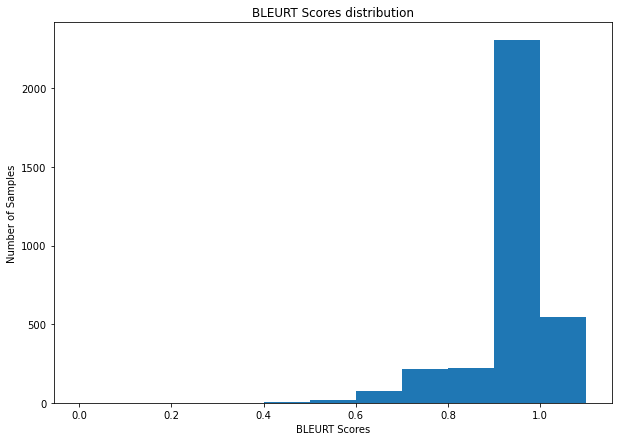

In [29]:
fig, ax = plt.subplots(figsize =(10, 7))
bins = [0.1*ctr for ctr in range(0, 12)]
ax.hist(em_bleurt, bins = bins)
plt.xlabel('BLEURT Scores')
plt.ylabel('Number of Samples')
plt.title('BLEURT Scores distribution')

 
# Show plot
plt.show()

In [94]:
# TODO: Analyze perplexity for Exact Match
print('Maximum Perplexity:', max(em_ppl))
print('Minimum Perplexity:', min(em_ppl))
print('Mean Perplexity:', mean(em_ppl))

Maximum Perplexity: 10.922181129455566
Minimum Perplexity: 1.0019041299819946
Mean Perplexity: 1.2683538149771005


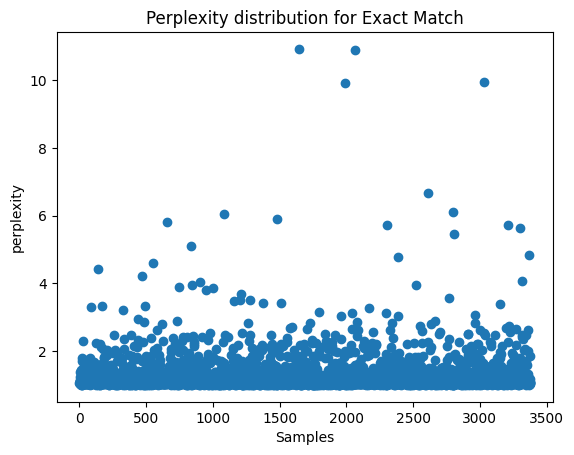

In [96]:
# Scatter plot of perplexity
num = [ctr+1 for ctr in range(len(em_ppl))]
plt.scatter(num, em_ppl)
plt.ylabel('perplexity')
plt.xlabel('Samples')
plt.title('Perplexity distribution for Exact Match')
plt.show()

In [44]:
# # NOTE: generated contained in ground-truth
# grp_pair_ids = ans_df.groupby('pair_id')
# valid_quests = defaultdict(list)
# attrs, ls, ei = [], [], []
# all_attrs, all_ls, all_ei = [], [], []
# for grp_full in grp_pair_ids:
#     grp = grp_full[1]
#     # store main information
#     all_attrs.append(grp['attribute1'].tolist()[0])
#     all_ls.append(grp['local_or_sum'].tolist()[0])
#     all_ei.append(grp['ex_or_im'].tolist()[0])
#     flag = True
#     for i, row in grp.iterrows():
#         if clean_str(row['answer']) in clean_str(row['generated_answer']):
#             valid_quests[row['pair_id']].append(row['generated_question'])
#             if flag:
#                 attrs.append(row['attribute1'])
#                 ls.append(row['local_or_sum'])
#                 ei.append(row['ex_or_im'])
#                 flag = False

In [45]:
# print('Stats for generated contained in ground-truth match')
# get_stats_of_matching(valid_quests, attrs, ls, ei, all_attrs, all_ls, all_ei)

Stats for generated contained in ground-truth match
Samples with atleast one match: 3637
############################
Fraction matches by attribute type:
prediction : 0.37
setting : 0.81
action : 0.70
causal relationship : 0.38
outcome resolution : 0.61
feeling : 0.65
character : 0.82
############################
Fraction matches by locality:
summary : 0.19
local : 0.64
############################
Fraction matches by explicit/implicit:
explicit : 0.74
implicit : 0.20
############################


In [79]:
# ans_df = pd.read_csv('answer_nucleus_flan_t5_large_0.95_1.20.csv')
# ppl_df = pd.read_csv('ppl_answer_nucleus_flan_t5_large_0.95_1.20.csv')
# ppl_df['generated_answer'] = ans_df['generated_answer']
# ppl_df = ppl_df[['pair_id', 'prompt', 'answer', 'generated_answer', 'perplexity']]
# ppl_df.to_csv('ppl_answer_nucleus_flan_t5_large_0.95_1.20.csv', index=False)
# ppl_df.head()

,pair_id,prompt,answer,generated_answer,perplexity
0,23ce8aec4b32591b,Generate answer from story and question:\nThe ...,a horse,a horse,1.052149
1,23ce8aec4b32591b,Generate answer from story and question:\nThe ...,a horse,a horse for his journey,2.092725
2,23ce8aec4b32591b,Generate answer from story and question:\nThe ...,a horse,a horse for his journey,2.095316
3,23ce8aec4b32591b,Generate answer from story and question:\nThe ...,a horse,a horse for his journey,2.720231
4,23ce8aec4b32591b,Generate answer from story and question:\nThe ...,a horse,a horse,1.052216
